# Assignment 4 Time Series

In [35]:
import pandas as pd

file_paths = {
    'Value_of_Shipments': '33IVS.xlsx',
    'New_Orders': '33INO.xlsx',
    'Total_Inventory': '33ITI.xlsx',
    'Unfilled_Orders': '33IUO.xlsx',
}

def load_and_prepare_data(file_path, column_name):
    df = pd.read_excel(file_path, skiprows=7)
    df['Period'] = pd.to_datetime(df['Period']).dt.to_period('M').dt.to_timestamp('M')
    df.set_index('Period', inplace=True)
    df.rename(columns={'Value': column_name}, inplace=True)
    return df

dataframes = {name: load_and_prepare_data(path, name) for name, path in file_paths.items()}

base_df = dataframes.pop('Value_of_Shipments')
for name, df in dataframes.items():
    base_df = base_df.join(df, how='inner')

combined_df = base_df.reset_index()

combined_df


,Period,Value_of_Shipments,New_Orders,Total_Inventory,Unfilled_Orders
0,1992-01-31,1303.0,NaN,4385.0,7020.0
1,1992-02-29,1453.0,1403.0,4302.0,6970.0
2,1992-03-31,1605.0,1418.0,4372.0,6783.0
3,1992-04-30,1578.0,1562.0,4294.0,6767.0
4,1992-05-31,1637.0,1568.0,4306.0,6698.0
...,...,...,...,...,...
391,2024-08-31,NaN,NaN,NaN,NaN
392,2024-09-30,NaN,NaN,NaN,NaN
393,2024-10-31,NaN,NaN,NaN,NaN
394,2024-11-30,NaN,NaN,NaN,NaN


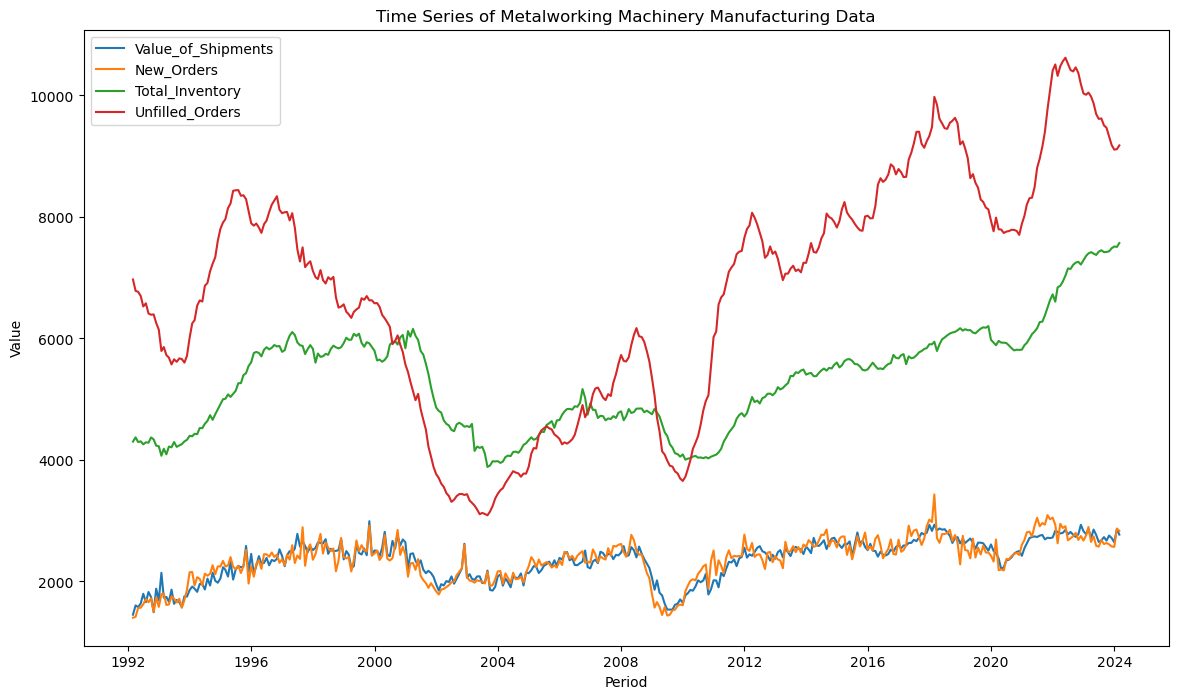

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


combined_df.dropna(inplace=True)

plt.figure(figsize=(14, 8))
for column in combined_df.columns[1:]:
    plt.plot(combined_df['Period'], combined_df[column], label=column)
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Time Series of Metalworking Machinery Manufacturing Data')
plt.legend()
plt.show()




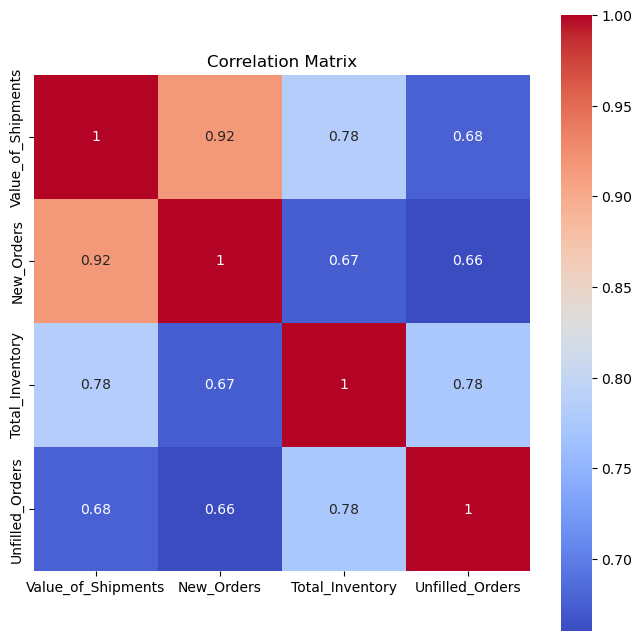

In [37]:
correlation_matrix = combined_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, square=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Handling NA values

In [44]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np

data_for_var = combined_df.drop('Period', axis=1).dropna()
data_for_var

,Value_of_Shipments,New_Orders,Total_Inventory,Unfilled_Orders
1,1453.0,1403.0,4302.0,6970.0
2,1605.0,1418.0,4372.0,6783.0
3,1578.0,1562.0,4294.0,6767.0
4,1637.0,1568.0,4306.0,6698.0
5,1797.0,1625.0,4257.0,6526.0
...,...,...,...,...
381,2756.0,2610.0,7434.0,9321.0
382,2714.0,2576.0,7484.0,9183.0
383,2645.0,2569.0,7513.0,9107.0
384,2863.0,2871.0,7506.0,9115.0


### Checking Stationarity & Differencing it before fitting the VAR model

In [39]:
def check_stationarity(data, signif=0.05, verbose=False):
    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        return result[1]  

    p_values = data.apply(adf_test, axis=0)
    if verbose:
        print("P-values for the ADF test of stationarity:")
        print(p_values)
    return p_values <= signif

is_stationary = check_stationarity(data_for_var, verbose=True)
if not is_stationary.all():
    data_for_var = data_for_var.diff().dropna()



P-values for the ADF test of stationarity:
Value_of_Shipments    0.159589
New_Orders            0.014895
Total_Inventory       0.797556
Unfilled_Orders       0.693923
dtype: float64


### Multicolinearity and Outlier detection, if any

In [43]:
import pandas as pd
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor

def adf_test(series, signif=0.05):
    p_value = adfuller(series, autolag='AIC')[1]
    return p_value

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

def find_outliers(data, threshold=3):
    z_scores = zscore(data)
    abs_z_scores = np.abs(z_scores)
    return (abs_z_scores > threshold).any(axis=1)


print("Checking for stationarity:")
stationarity_p_values = data_for_var.apply(adf_test)
print(stationarity_p_values > 0.05)


print("Checking for multicollinearity:")
vif_data = calculate_vif(data_for_var)
print(vif_data)


print("Detecting outliers:")
outliers = find_outliers(data_for_var)
print(f"Number of outlier observations: {outliers.sum()}")


Checking for stationarity:
Value_of_Shipments    False
New_Orders            False
Total_Inventory       False
Unfilled_Orders       False
dtype: bool
Checking for multicollinearity:
              feature       VIF
0  Value_of_Shipments  1.619775
1          New_Orders  1.983696
2     Total_Inventory  1.093109
3     Unfilled_Orders  1.508873
Detecting outliers:
Number of outlier observations: 17


**Summary of the results**

Initially, the Augmented Dickey-Fuller (ADF) test was applied to assess the stationarity of the time series data. The p-values indicated that except for New_Orders, all series (Value_of_Shipments, Total_Inventory, and Unfilled_Orders) were not stationary since their p-values exceeded 0.05. After differencing the data once, the ADF test revealed that all variables turned stationary as the p-values fell below the 0.05 threshold, indicated by False for each variable in the stationarity check, thereby making it suitable for VAR modeling. The subsequent checks for multicollinearity using Variance Inflation Factor (VIF) showed VIF values less than 5, suggesting that multicollinearity is not a problem. However, there were 17 outlier detected in the dataset.

## Fitting a VAR(1) model

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_for_var_scaled = pd.DataFrame(scaler.fit_transform(data_for_var), columns=data_for_var.columns)

try:
    model = VAR(data_for_var_scaled)
    results = model.fit(1)
    print("Successfully fitted VAR model with standardized data.")
    print(results.summary())
except LinAlgError:
    print("Still encountered an error with standardized data.")


Successfully fitted VAR model with standardized data.
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Apr, 2024
Time:                     20:25:38
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -49.0107
Nobs:                     384.000    HQIC:                  -49.1349
Log likelihood:           7290.08    FPE:                4.22227e-22
AIC:                     -49.2165    Det(Omega_mle):     5.14443e-22
--------------------------------------------------------------------
Results for equation Value_of_Shipments
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.010962         0.018671            0.587           0.557
L1.Value_of_Shipments         0.510174         0.0

1. Residual Analysis
Ouput for the Durbin-Watson statistics:
Durbin-Watson statistic for Value_of_Shipments: 2.60362
Durbin-Watson statistic for New_Orders: 2.47609
Durbin-Watson statistic for Total_Inventory: 2.10565
Durbin-Watson statistic for Unfilled_Orders: 2.09819
Testing for normality of residuals using Jarque-Bera

Jarque-Bera test statistics: [ 74.06778668  17.42124943 223.3061339    6.92312093]
Jarque-Bera test p-value: [8.24868046e-17 1.64825254e-04 3.23362114e-49 3.13807553e-02]


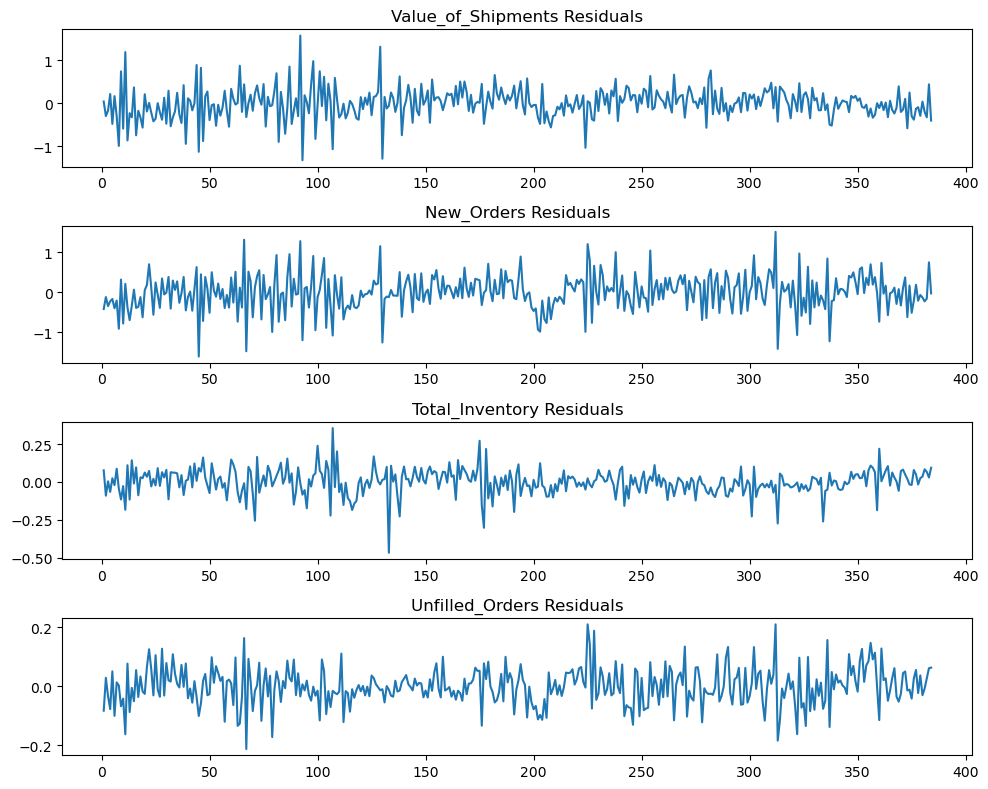

In [15]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt


print("1. Residual Analysis")
print("Ouput for the Durbin-Watson statistics:")
dw_stats = durbin_watson(results.resid)

for col, stat in zip(data_for_var.columns, dw_stats):
    print(f'Durbin-Watson statistic for {col}: {stat:.5f}')

print("Testing for normality of residuals using Jarque-Bera\n")
jb_test = jarque_bera(results.resid)
print(f'Jarque-Bera test statistics: {jb_test[0]}')
print(f'Jarque-Bera test p-value: {jb_test[1]}')

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    if isinstance(results.resid, np.ndarray):
        ax.plot(results.resid[:, i])
    else:  
        ax.plot(results.resid.iloc[:, i])
    ax.set_title(data_for_var.columns[i] + ' Residuals')
plt.tight_layout()
plt.show()



In [16]:
lag_order = results.k_ar
last_obs = data_for_var_scaled.values[-lag_order:]
forecast = results.forecast(last_obs, steps=1)
forecast_original_scale = scaler.inverse_transform(forecast)
print("Forecasted values for the next time step in original scale:")
print(forecast_original_scale)


Forecasted values for the next time step in original scale:
[[2852.10549972 2800.6617469  7548.31294762 9125.55624718]]


**VAR(1) Model Summary Inference**

The model's fit indicated by AIC, BIC, and log likelihood, suggests that the model is relatively well-fitted to the data.


The residuals are uncorrelated as suggested by the Durbin-Watson statistics which are all close to 2, suggesting no strong evidence of first or second-order autocorrelation, but there are significant correlations between Value_of_Shipments and New_Orders, and between New_Orders and Unfilled_Orders. This suggests some possible interaction effects between these variables not fully captured by the model which is indicated by the Jarque-Bera test, which rejects the hypothesis of normality for residuals of Value_of_Shipments, New_Orders, and Total_Inventory due to very low p-values, indicating that the residuals for these series are not normally distributed. The residual plots visually highlights these findings, showing fluctuations around zero without obvious patterns, which is good, but with some deviations from normality, indicated by the spread and occasional spikes. The results suggest the model captures the time series adequately, though the assumption of normally distributed residuals does not hold for all series.


Additionally, there is a notable negative relationship between Value_of_Shipments at lag 1 and Unfilled_Orders, indicating an inverse relationship between past values of shipments and current unfilled orders.

**The forcast using this model is for value_of_shipment: 2852.10**

## Fitting a VAR(p) model with p = 3.

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_for_var_scaled = pd.DataFrame(scaler.fit_transform(data_for_var), columns=data_for_var.columns)

try:
    model = VAR(data_for_var_scaled)
    results = model.fit(maxlags=3, ic='aic')
    print("Successfully fitted VAR model with standardized data.")
    print(results.summary())
except LinAlgError:
    print("Still encountered an error with standardized data.")


Successfully fitted VAR model with standardized data.
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Apr, 2024
Time:                     21:39:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -50.6139
Nobs:                     382.000    HQIC:                  -50.9379
Log likelihood:           7653.70    FPE:                6.10190e-23
AIC:                     -51.1510    Det(Omega_mle):    -7.86779e-23
--------------------------------------------------------------------
Results for equation Value_of_Shipments
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.009364              NAN              NAN             NAN
L1.Value_of_Shipments         0.237033            

1. Residual Analysis
Ouput for the Durbin-Watson statistics:
Durbin-Watson statistic for Value_of_Shipments: 1.98842
Durbin-Watson statistic for New_Orders: 1.99823
Durbin-Watson statistic for Total_Inventory: 1.99678
Durbin-Watson statistic for Unfilled_Orders: 2.02224

Testing for normality of residuals using Jarque-Bera
Jarque-Bera test statistics: [143.27181798  15.00870832 267.71847353   5.20679376]
Jarque-Bera test p-value: [7.74319183e-32 5.50681387e-04 7.33959543e-59 7.40217079e-02]


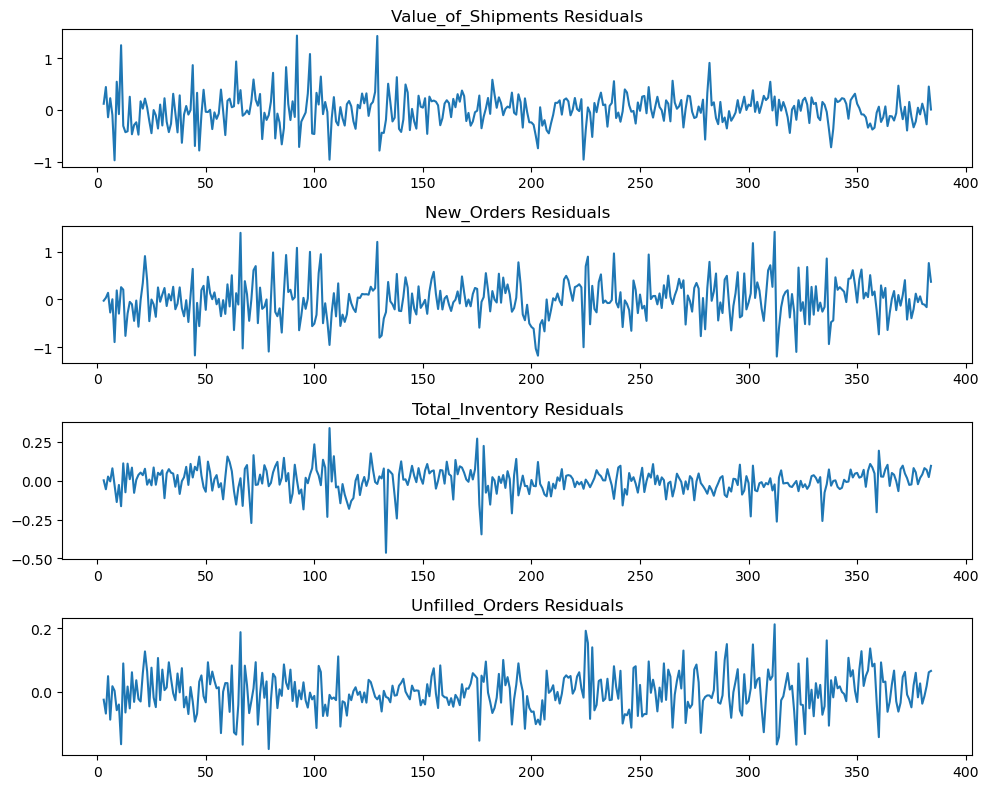

In [50]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt


print("1. Residual Analysis")
print("Ouput for the Durbin-Watson statistics:")
dw_stats = durbin_watson(results.resid)

for col, stat in zip(data_for_var.columns, dw_stats):
    print(f'Durbin-Watson statistic for {col}: {stat:.5f}')

print("\nTesting for normality of residuals using Jarque-Bera")
jb_test = jarque_bera(results.resid)
print(f'Jarque-Bera test statistics: {jb_test[0]}')
print(f'Jarque-Bera test p-value: {jb_test[1]}')

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    if isinstance(results.resid, np.ndarray):
        ax.plot(results.resid[:, i])
    else:  # results.resid is a DataFrame
        ax.plot(results.resid.iloc[:, i])
    ax.set_title(data_for_var.columns[i] + ' Residuals')
plt.tight_layout()
plt.show()



In [47]:
lag_order_p = results.k_ar
last_obs_p = data_for_var_scaled.values[-lag_order_p:]
forecast_p = results.forecast(last_obs_p, steps=1)
forecast_original_scale_p = scaler.inverse_transform(forecast_p)
print("Forecasted values for the next time step in original scale:")
print(forecast_original_scale_p)


Forecasted values for the next time step in original scale:
[[2820.43454169 2788.37367931 7543.68849015 9144.93913762]]


**VAR(p) Model Summary Inference (p=3)**

The VAR(3) model, with three lags is a good fit as indicated by relatively high log-likelihood and low AIC, BIC, and FPE. Coefficients for lagged values across all equations exhibit various degrees of influence, with some lags demonstrating significant predictive power at certain lags, for example L1.Total_Inventory strongly predicts its own future values. However, standard errors are not available for many coefficients, which requires further investigation.

The Durbin-Watson statistics for all variables are close to 2, suggesting no major issues with autocorrelation in the residuals. The Jarque-Bera test shows that residuals for New_Orders and Unfilled_Orders are not normally distributed, given the low p-values. The residual plots confirm the lack of patterns, indicating no missed trends or seasonality, but the spread and outliers hint at non-normality, aligning with the Jarque-Bera test results. 

Overall, the model captures the interdependencies among variables up to three periods back, but some diagnostics indicate potential issues with residual distribution.

**The forcast using this model is for value_of_shipment: 2820.43**

### Granger Causality Test

In [52]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3  
test = 'ssr_chi2test'  

data_granger = data_for_var[['New_Orders','Value_of_Shipments']]
gc_results = grangercausalitytests(data_granger, maxlag=maxlag, verbose=True, addconst=True)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.9903 , p=0.0000  , df_denom=381, df_num=1
ssr based chi2 test:   chi2=17.1240 , p=0.0000  , df=1
likelihood ratio test: chi2=16.7532 , p=0.0000  , df=1
parameter F test:         F=16.9903 , p=0.0000  , df_denom=381, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8596  , p=0.0219  , df_denom=378, df_num=2
ssr based chi2 test:   chi2=7.8214  , p=0.0200  , df=2
likelihood ratio test: chi2=7.7426  , p=0.0208  , df=2
parameter F test:         F=3.8596  , p=0.0219  , df_denom=378, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0717  , p=0.3610  , df_denom=375, df_num=3
ssr based chi2 test:   chi2=3.2751  , p=0.3511  , df=3
likelihood ratio test: chi2=3.2611  , p=0.3531  , df=3
parameter F test:         F=1.0717  , p=0.3610  , df_denom=375, df_num=3


In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3  
test = 'ssr_chi2test'  

data_granger = data_for_var[['Total_Inventory','Value_of_Shipments']]
gc_results = grangercausalitytests(data_granger, maxlag=maxlag, verbose=True, addconst=True)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6300 , p=0.0002  , df_denom=381, df_num=1
ssr based chi2 test:   chi2=14.7452 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4692 , p=0.0001  , df=1
parameter F test:         F=14.6300 , p=0.0002  , df_denom=381, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0120  , p=0.0004  , df_denom=378, df_num=2
ssr based chi2 test:   chi2=16.2360 , p=0.0003  , df=2
likelihood ratio test: chi2=15.9013 , p=0.0004  , df=2
parameter F test:         F=8.0120  , p=0.0004  , df_denom=378, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6523  , p=0.0128  , df_denom=375, df_num=3
ssr based chi2 test:   chi2=11.1615 , p=0.0109  , df=3
likelihood ratio test: chi2=11.0015 , p=0.0117  , df=3
parameter F test:         F=3.6523  , p=0.0128  , df_denom=375, df_num=3


In [54]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3  
test = 'ssr_chi2test'  

data_granger = data_for_var[['Unfilled_Orders','Value_of_Shipments']]
gc_results = grangercausalitytests(data_granger, maxlag=maxlag, verbose=True, addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7292  , p=0.3937  , df_denom=381, df_num=1
ssr based chi2 test:   chi2=0.7349  , p=0.3913  , df=1
likelihood ratio test: chi2=0.7342  , p=0.3915  , df=1
parameter F test:         F=0.7292  , p=0.3937  , df_denom=381, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9109  , p=0.4030  , df_denom=378, df_num=2
ssr based chi2 test:   chi2=1.8460  , p=0.3973  , df=2
likelihood ratio test: chi2=1.8415  , p=0.3982  , df=2
parameter F test:         F=0.9109  , p=0.4030  , df_denom=378, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1161  , p=0.3424  , df_denom=375, df_num=3
ssr based chi2 test:   chi2=3.4108  , p=0.3325  , df=3
likelihood ratio test: chi2=3.3957  , p=0.3345  , df=3
parameter F test:         F=1.1161  , p=0.3424  , df_denom=375, df_num=3


**Granger Causality Test summary**


1. There is strong evidence to suggest that New_Orders Granger-causes Value_of_Shipments, as indicated by very low p-values across all statistical tests (F-test, chi-squared test, and likelihood ratio test) AT Lag 1. However, the evidence becomes weaker with increasing lags.This suggests that recent changes in New_Orders are relevant for forecasting Value_of_Shipments, but their influence does not persist beyond the immediate past.


2. For Unfilled_Orders predicting Value_of_Shipments, the Granger causality tests show high p-values (above 0.05) across all tests and lag intervals. This suggests there is no statistical evidence to conclude that Unfilled_Orders Granger-cause Value_of_Shipments.

3. For Total_Inventory predicting Value_of_Shipments, the situation is different. The Granger causality tests indicate statistical significance at the 1-lag and 2-lags intervals with p-values well below 0.05, suggesting that Total_Inventory does Granger-cause Value_of_Shipments. However, the p-value rises above 0.05 at lag 3, indicating that the causality does not hold for longer lag length.

From these results, it seems that New_Orders and Total_Inventory has a predictive relationship with Value_of_Shipments in the short term (1-2 lags), whereas Unfilled_Orders does not show a strong predictive relationship with Value_of_Shipments.

### BigVAR package to fit a sparse VAR model in Python

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


X = lagged_df.drop(['Value_of_Shipments'], axis=1) 
y = lagged_df['Value_of_Shipments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LassoCV(cv=5).fit(X_train, y_train)

print(f"Best alpha: {model.alpha_}")
print(f"Model coefficients: {model.coef_}")

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")


Best alpha: 454.9687064767537
Model coefficients: [ 0.04141858  0.04991928  0.01960433  0.83455298  0.00779028  0.00085019
  0.00761588  0.          0.01105336  0.          0.         -0.73138957
  0.71340968  0.01265117  0.00660226]
MSE: 755.5733587117902


In [32]:
predictors = X_train.columns

model_coefficients = [0.04141858, 0.04991928, 0.01960433, 0.83455298, 0.00779028, 0.00085019,
                      0.00761588, 0., 0.01105336, 0., 0., -0.73138957,
                      0.71340968, 0.01265117, 0.00660226]

coefficient_predictor_map = dict(zip(predictors, model_coefficients))

for predictor, coefficient in coefficient_predictor_map.items():
    if coefficient == 0.83455298:
        print(f"The predictor with coefficient 0.83455298 is {predictor}.")
    elif coefficient == -0.73138957:
        print(f"The predictor with coefficient -0.73138957 is {predictor}.")


The predictor with coefficient 0.83455298 is New_Orders.
The predictor with coefficient -0.73138957 is Unfilled_Orders.


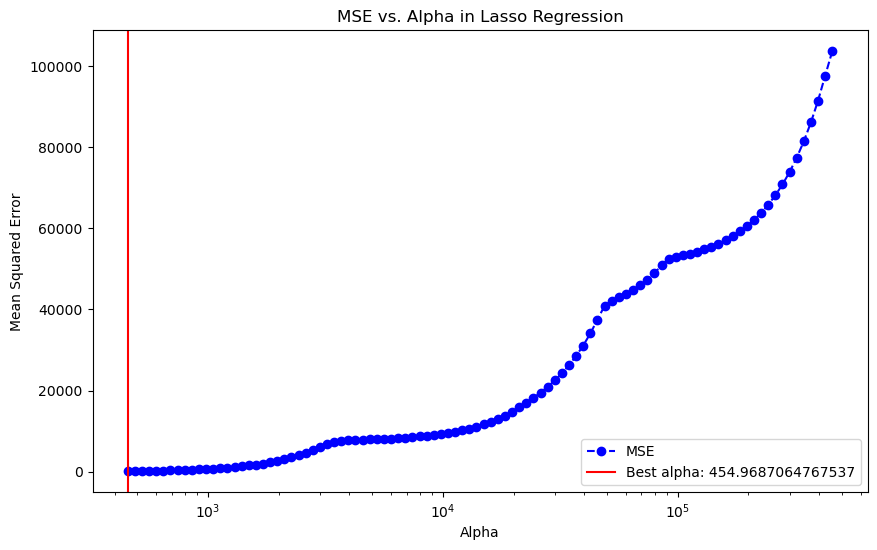

In [33]:
import matplotlib.pyplot as plt


best_alpha = model.alpha_

alphas_tested = model.alphas_


mse_means = model.mse_path_.mean(axis=1)

plt.figure(figsize=(10, 6))

plt.plot(alphas_tested, mse_means, marker='o', linestyle='--', color='b', label='MSE')

plt.axvline(x=best_alpha, linestyle='-', color='r', label=f'Best alpha: {best_alpha}')

plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')  
plt.title('MSE vs. Alpha in Lasso Regression')
plt.legend()
plt.show()


**Sparsity structure and result explanation**

I researched quite a few documentations and found that there are a few github libraries that provide their own BigVar implementation for python as it doesnt directly have any such package. (one of the few links : https://github.com/wbnicholson/BigVAR/blob/master/python/BigVAR/BigVARClass.py). However, they have created their own versions of the package by creating a class. Instead, I used Lasso regression in Python as a substitute for the BigVAR approach because both techniques aim to create sparse models by penalizing less important features, thus reducing model complexity in high-dimensional datasets. Lasso, like BigVAR, encourages sparsity, which simplifies the model by shrinking certain coefficients to zero, effectively selecting the most relevant predictors. This is particularly useful when dealing with time-series data that contain many interrelated variables(here it can refer to covariate series), where traditional VAR models might overfit or become unmanageable.

**Best alpha here is 454.9**